# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer, StandardScaler
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',';')

In [3]:
feat_info[feat_info['attribute']=='CAMEO_DEU_2015']

,attribute,information_level,type,missing_or_unknown
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f"Shape of demographic data: {azdias.shape} \n\n",
      azdias.head(),
      f"Shape of feature info: {feat_info.shape} \n\n",
      feat_info.head());


Shape of demographic data: (891221, 85) 

    AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...          

In [33]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [34]:
pd.set_option('display.max_rows',None)
with open('Data_Dictionary.md','r') as f:
    data_dict = f.read()
print(data_dict)
feat_info

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [35]:
pd.set_option('display.max_rows',0)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [36]:
azdias['GFK_URLAUBERTYP'].value_counts()

12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
 
feat_info['missing_ints'] = np.array('')
z = 0
for x, y in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
    nan_codes = y.strip('[]').split(',')
    new_nan_codes = []
    if len(y) > 2:
        for c in nan_codes:
            try:
                new_nan_codes.append(int(c))
            except ValueError:
                new_nan_codes.append(c)
    else:
        new_nan_codes = []
    feat_info['missing_ints'][z] = new_nan_codes
    z += 1


In [6]:
#replaces missing/unknown value markers with nan
for x,y in zip(feat_info['attribute'], feat_info['missing_ints']):
    for num in y:
        azdias.loc[azdias[x]==num,x] = np.nan
    try:
        azdias[x] = pd.to_numeric(azdias[x])
    except:
        print(f"{x} is non-numeric")

OST_WEST_KZ is non-numeric
CAMEO_DEU_2015 is non-numeric


In [7]:
azdias.head(4)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(891221, 85)


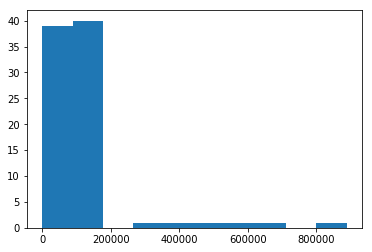

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

null_vals = [sum(azdias[x].isnull()) for x in feat_info['attribute']]
plt.hist(null_vals)
print(azdias.shape)



The histogram above shows that 40 columns have between 88,906 and 177,812 null values. Only 6 columns have >177812 null values

In [9]:
# Investigate patterns in the amount of missing data in each column.
feat_info['null_vals'] = np.array(null_vals)
feat_info.head()


,attribute,information_level,type,missing_or_unknown,missing_ints,null_vals
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]",685843
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]",2881
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]",0
3,CJT_GESAMTTYP,person,categorical,[0],[0],4854
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1],0


In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Drops columns missing anything greater than 20% of total rows. In present case, this will be 6 columns.
z = 0
r = 0
threshold = azdias.shape[0]*.2
for x in azdias:
    if sum(azdias[x].isnull()) > threshold:
        azdias.drop(x, axis=1, inplace=True)
        feat_info.drop(feat_info[feat_info['attribute']==x].index[0],inplace=True)
        print(f"Dropped {x}")
        r += 1
print(f"Dropped {r} columns")


Dropped AGER_TYP
Dropped GEBURTSJAHR
Dropped TITEL_KZ
Dropped ALTER_HH
Dropped KK_KUNDENTYP
Dropped KBA05_BAUMAX
Dropped 6 columns


In [51]:
# # shortcut to drop above columns from azdias
# cols = ["AGER_TYP","GEBURTSJAHR","TITEL_KZ","ALTER_HH","KK_KUNDENTYP","KBA05_BAUMAX"]
# azdias.drop(cols, axis=1, inplace=True)

# # shortcut to drop from rows in feat_info
# for x in cols:
#     feat_info.drop(feat_info[feat_info['attribute']==x].index[0],inplace=True)

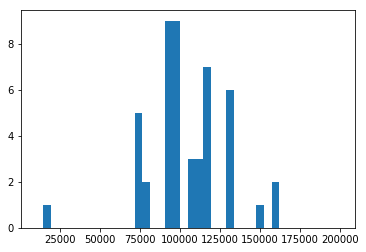

In [11]:
#This shows the number of columns with a sum of missing values between 10000 and 200000
plt.hist(null_vals, bins=40, range=(10000,200000));

In [12]:
for x in azdias:
    if 50000< sum(azdias[x].isnull()) < 175000:
        s = sum(azdias[x].isnull())
        print(f"{x} contains {s} null values")

HEALTH_TYP contains 111196 null values
LP_LEBENSPHASE_FEIN contains 97632 null values
LP_LEBENSPHASE_GROB contains 94572 null values
LP_FAMILIE_FEIN contains 77792 null values
LP_FAMILIE_GROB contains 77792 null values
NATIONALITAET_KZ contains 108315 null values
PRAEGENDE_JUGENDJAHRE contains 108164 null values
SHOPPER_TYP contains 111196 null values
SOHO_KZ contains 73499 null values
VERS_TYP contains 111196 null values
ANZ_PERSONEN contains 73499 null values
ANZ_TITEL contains 73499 null values
W_KEIT_KIND_HH contains 147988 null values
WOHNDAUER_2008 contains 73499 null values
ANZ_HAUSHALTE_AKTIV contains 99611 null values
ANZ_HH_TITEL contains 97008 null values
GEBAEUDETYP contains 93148 null values
KONSUMNAEHE contains 73969 null values
MIN_GEBAEUDEJAHR contains 93148 null values
OST_WEST_KZ contains 93148 null values
WOHNLAGE contains 93148 null values
CAMEO_DEUG_2015 contains 99352 null values
CAMEO_DEU_2015 contains 99352 null values
CAMEO_INTL_2015 contains 99352 null values


#### Discussion 1.1.2: Assess Missing Data in Each Column

As mentioned above, all of the columns with > 20% missing or unknown values were removed. Those columns include:
- best-ager typology
- year of birth
- academic title flag
- head of household birthday
- consumer history over past 12 months
- most common building type in micrcell

In other cases of high missing values, there is frequent uniformity between columns of the same grouping. For example, all of the columns dealing with microcells have identical amounts of missing or unknown values (133,324).

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [52]:
# How much data is missing in each row of the dataset?
azdias['missing'] = azdias.apply(lambda x: 79 - x.count(), axis=1)

In [53]:
missing_dict = {}
for x in azdias['missing']:
    if x in missing_dict:
        missing_dict[x] += 1
    else:
        missing_dict[x] = 1
print(missing_dict)

{38: 73499, 0: 697859, 1: 28202, 6: 12846, 8: 17240, 10: 4663, 19: 1138, 33: 18684, 5: 161, 3: 7322, 7: 3703, 29: 9, 17: 557, 2: 10094, 15: 4539, 4: 343, 9: 755, 34: 385, 14: 2165, 11: 590, 16: 2296, 26: 19, 18: 251, 32: 480, 20: 54, 13: 3077, 43: 99, 23: 26, 44: 1, 25: 36, 12: 65, 21: 41, 24: 12, 27: 5, 22: 4, 28: 1}


In [54]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_miss = pd.DataFrame(azdias.loc[azdias['missing']>=11])
azdias = pd.DataFrame(azdias.loc[azdias['missing'] < 11])

In [55]:
azdias_miss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing
0,2,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38
11,2,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38
14,3,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38
17,2,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38
24,3,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38


In [56]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#shows percentages of missing values
total_have = azdias.shape[0]
total_miss = azdias_miss.shape[0]
test_columns = ['ANZ_HAUSHALTE_AKTIV','PLZ8_ANTG1','MOBI_REGIO','CAMEO_DEUG_2015','ARBEIT']
for x in test_columns:
    have_null = sum(azdias[x].isnull())
    miss_null = sum(azdias_miss[x].isnull())
    print(x, have_null/total_have * 100, miss_null/total_miss * 100)


ANZ_HAUSHALTE_AKTIV 0.0 86.2218025974
PLZ8_ANTG1 1.14340362723 99.5621708182
MOBI_REGIO 3.30393213379 99.458498792
CAMEO_DEUG_2015 0.443060925346 88.4072459341
ARBEIT 0.501412176898 86.3523182731


#### Discussion 1.1.3: Assess Missing Data in Each Row

All of the columns above have very different percentages of missing values. They might be considered special. There's obviously a qualitative difference between rows missing 10 data points and rows missing 47 data points (of which there are nearly 50,000). 

In [57]:
azdias.drop('missing',axis=1, inplace=True)
azdias_miss.drop('missing',axis=1, inplace = True)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [58]:
feat_info.head(1)

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [59]:
# How many features are there of each data type?
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info['type'].value_counts()


ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [61]:
#Reincode non-binary values
#good tutorial on this: http://www.handsonmachinelearning.com/blog/McTKK/python-one-hot-encoding-with-scikit-learn
categorical_attributes = feat_info[feat_info['type']=='categorical']['attribute']

In [67]:
categorical_attributes

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [74]:
for att in categorical_attributes:
    print(azdias[att].value_counts())

2    408554
1    374634
Name: ANREDE_KZ, dtype: int64
4.0    194007
3.0    143995
2.0    139972
5.0    109868
6.0     99400
1.0     91617
Name: CJT_GESAMTTYP, dtype: int64
6    287378
1    193874
5    104884
2    102772
4     55289
3     38991
Name: FINANZTYP, dtype: int64
12.0    126076
10.0    101630
8.0      81992
11.0     74084
5.0      69990
4.0      60210
9.0      55932
3.0      53008
1.0      50260
7.0      40150
2.0      39964
6.0      25563
Name: GFK_URLAUBERTYP, dtype: int64
0    611168
1    172020
Name: GREEN_AVANTGARDE, dtype: int64
1.0     395942
10.0    127369
2.0      96295
11.0     48270
0.0      26200
8.0      21347
7.0      18718
4.0      11263
5.0      10982
9.0      10291
6.0       7777
3.0       4405
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    395942
5.0    185930
2.0     96295
4.0     47842
3.0     26650
0.0     26200
Name: LP_FAMILIE_GROB, dtype: int64
1.0     205077
9.0     131600
2.0     110510
10.0    109475
4.0      73469
3.0      68487
6.0      28295
5.0     

<h3>Categories that need addressing prior to one-hot encoding</h3>
- OST_WEST_KZ is binary but with alphabetical markers W and O. Need to change change it to numerical. 
- CAMEO_DEU_2015 will need to be value encoded because it uses non-numerical classification (and also non-binary).

In [75]:
azdias['CAMEO_DEU_2015'][0:5]

1    8A
2    4C
3    2A
4    6B
5    8C
Name: CAMEO_DEU_2015, dtype: object

In [76]:
#change label of non-numerical category to numerical (so one-hot encoder can work)
le_cameod = LabelEncoder()
azdias['CAMEO_DEU_2015_ENCODED'] = le_cameod.fit_transform(azdias['CAMEO_DEU_2015'].astype(str))

In [78]:
categorical_attributes.drop(categorical_attributes[categorical_attributes=='CAMEO_DEU_2015'].index[0])

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
Name: attribute, dtype: object

In [79]:
#Drop non-encoded column
azdias.drop(['CAMEO_DEU_2015'],axis=1, inplace=True)

In [83]:
#Change West Germany to 1 and East Germany to 0 
azdias.loc[azdias['OST_WEST_KZ']=='O','OST_WEST_KZ'] = 0
azdias.loc[azdias['OST_WEST_KZ']=='W','OST_WEST_KZ'] = 1
azdias.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_DEU_2015_ENCODED
1,1,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,35
2,3,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,15


In [ ]:
#Re-label non-numerical variable
# le_cameod = LabelEncoder()
# azdias['CAMEO_DEU_2015_ENCODED'] = le_cameod.fit_transform(azdias['CAMEO_DEU_2015'].astype(str))
# categorical_attributes.drop(categorical_attributes[categorical_attributes=='CAMEO_DEU_2015'].index[0])

# Re-encode categorical variable(s) to be kept in the analysis.
for x in categorical_attributes:
    if x in azdias.columns and len(azdias[x].value_counts())>2:
        #One-hot encode column
        enc = OneHotEncoder()
        filler = 500
        azdias[x] = azdias[x].fillna(filler)
        ENCODED = enc.fit_transform(azdias[x].values.reshape(-1,1)).toarray()
        dfOneHot = pd.DataFrame(ENCODED, columns = [x + "__" + str(int(i)) for i in range(ENCODED.shape[1])])
        azdias = pd.concat([azdias, dfOneHot], axis=1)
        
        #drop original column
        azdias.drop(x, axis=1, inplace = True)

In [ ]:
azdias.shape

In [ ]:
azdias.head(2)

#### Discussion 1.2.1: Re-Encode Categorical Features

I kept all of the categorical features and one-hot encoded all of them. Additionally, i had to re-encode the labels for one of the columns that originally had alphabetical labeling. Then, I one-hot encoded that column as well. The data is now much more sparse and there are many more columns to deal with, but at this point it seems better to have too much data than not enough. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [24]:
feat_info[feat_info['type']=='mixed']

,attribute,information_level,type,missing_or_unknown,missing_ints
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0],[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]","[-1, 0]"
56,WOHNLAGE,building,mixed,[-1],[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]","[-1, XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]","[-1, 0]"


In [87]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    178915
8.0     139071
10.0     84108
5.0      83821
3.0      53230
15.0     41138
11.0     34727
9.0      33249
0.0      27567
6.0      25548
12.0     24067
1.0      20389
4.0      20362
2.0       7458
13.0      5570
7.0       3968
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

NEED "an interval-type variable for decade, and a binary variable for movement."

In [26]:
# #interval for decade in PRAEGENDE_JUGENDJAHRE
decades = [40,50,60,70,80,90]
variables = [[1,2],[3,4],[5,6,7],[8,9],[10,11,12,13],[14,15]]
azdias_have['PRAEGENDE_JUGENDJAHRE_DECADE'] = np.array(np.nan)
for l,m in zip(decades,variables):
    azdias_have.loc[azdias_have['PRAEGENDE_JUGENDJAHRE'].isin(m),'PRAEGENDE_JUGENDJAHRE_DECADE'] = l

1.0    20242
2.0     7438
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64
40.0    27680
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64
3.0    53098
4.0    20343
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64
50.0    73441
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64
5.0    83645
6.0    25517
7.0     3964
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64
60.0    113126
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64
8.0    138678
9.0     33197
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64
70.0    171875
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64
10.0    83881
11.0    34642
12.0    24034
13.0     5561
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64
80.0    148118
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64
14.0    178410
15.0     41029
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64
90.0    219439
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64


In [27]:
# #interval for decade in PRAEGENDE_JUGENDJAHRE
decades = [40,50,60,70,80,90]
variables = [[1,2],[3,4],[5,6,7],[8,9],[10,11,12,13],[14,15]]
azdias_have['PRAEGENDE_JUGENDJAHRE_DECADE'] = np.array(np.nan)
for l,m in zip(decades,variables):
    azdias_have.loc[azdias_have['PRAEGENDE_JUGENDJAHRE'].isin(m),'PRAEGENDE_JUGENDJAHRE_DECADE'] = l

#binary for movement in PRAEGENDE_JUGENDJAHRE
#Mainstream = 0, Avantgarde = 1
main = [1,3,5,8,10,12,14]
ava = [2,4,6,7,9,11,13,15]
# azdias_have['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = np.array(np.nan)
azdias_have.loc[azdias_have['PRAEGENDE_JUGENDJAHRE'].isin(main),'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 0
azdias_have.loc[azdias_have['PRAEGENDE_JUGENDJAHRE'].isin(ava),'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 1

#drop original column
df.drop('PRAEGEND_JUGENDJAHRE', axis=1, inplace=True)

main 581988
ava 171691
0.0    581988
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64
1.0    171691
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64


### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement

In [70]:
#CONVERT CAMEO_INTL_2015 to ints
# azdias_have['CAMEO_INTL_2015'] = pd.to_numeric(azdias_have['CAMEO_INTL_2015'])

In [28]:
#Wealth
wealthy = [11,12,13,14,15]
prosper = [21,22,23,24,25]
comfort = [31,32,33,34,35]
less = [41,42,43,44,45]
poorer = [51,52,53,54,55]
w_orig = [wealthy,prosper,comfort,less,poorer]
w_loc = [1,2,3,4,5]
#Life Stage
prefam = [11,21,31,41,51]
young = [12,22,32,42,52]
school = [13,23,33,43,53]
older = [14,24,34,44,54]
retire = [15,25,35,45,55]
l_orig = [prefam,young,school,older,retire]
l_loc = [1,2,3,4,5]
# azdias_have.loc[azdias_have['PRAEGENDE_JUGENDJAHRE'].isin(main),'PRAEGENDE_JUGENDJAHRE'].value_counts()
azdias_have.loc[azdias_have['CAMEO_INTL_2015'].isin(wealthy),'CAMEO_INTL_2015'][0:5]
azdias_have['CAMEO_INTL_2015_WEALTH'] = np.array(np.nan)
azdias_have['CAMEO_INTL_2015_LIFE'] = np.array(np.nan)
for x, y in zip(w_orig, w_loc):
    azdias_have.loc[azdias_have['CAMEO_INTL_2015'].isin(x),'CAMEO_INTL_2015_WEALTH'] = y
for c, d in zip(l_orig, l_loc):
    azdias_have.loc[azdias_have['CAMEO_INTL_2015'].isin(c),'CAMEO_INTL_2015_LIFE'] = d
    
azdias_have.drop('CAMEO_INTL_2015',axis=1)

In [29]:
print(azdias_have['CAMEO_INTL_2015_WEALTH'].value_counts(),
azdias_have['CAMEO_INTL_2015_LIFE'].value_counts())

5.0    221854
4.0    187271
2.0    184575
1.0    116706
3.0     66091
Name: CAMEO_INTL_2015_WEALTH, dtype: int64 1.0    241777
4.0    228456
3.0    115411
5.0    115187
2.0     75666
Name: CAMEO_INTL_2015_LIFE, dtype: int64


In [30]:
azdias_have.drop('CAMEO_INTL_2015',axis=1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEUG_2015__4,CAMEO_DEUG_2015__5,CAMEO_DEUG_2015__6,CAMEO_DEUG_2015__7,CAMEO_DEUG_2015__8,CAMEO_DEUG_2015__9,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,90.0,0.0,5.0,1.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0,2.0,4.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,1.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,70.0,0.0,4.0,3.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,50.0,0.0,5.0,4.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,2.0,2.0
7,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,1.0,4.0
8,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,1.0,1.0,3.0
9,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0,1.0,5.0


In [31]:
mixed_atts = feat_info[feat_info['type']=='mixed']['attribute']

In [46]:
print(mixed_atts)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [32]:
azdias_have.drop(mixed_atts,axis=1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEUG_2015__4,CAMEO_DEUG_2015__5,CAMEO_DEUG_2015__6,CAMEO_DEUG_2015__7,CAMEO_DEUG_2015__8,CAMEO_DEUG_2015__9,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,90.0,0.0,5.0,1.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0,2.0,4.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,1.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,70.0,0.0,4.0,3.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,50.0,0.0,5.0,4.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,2.0,2.0
7,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,1.0,4.0
8,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,1.0,1.0,3.0
9,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0,1.0,5.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

I re-engineered the two mixed-value types discussed above by creating two new columns for each of them, separating some of the variables originally combined into one column. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [35]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
for x in azdias_have.columns:
    print(x)


ALTERSKATEGORIE_GROB
ANREDE_KZ
CJT_GESAMTTYP
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GFK_URLAUBERTYP
GREEN_AVANTGARDE
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SHOPPER_TYP
SOHO_KZ
VERS_TYP
ZABEOTYP
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
GEBAEUDETYP
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
WOHNLAGE
CAMEO_DEUG_2015
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_K

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info['missing_ints'] = np.array('')
    z = 0
    for x, y in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
        nan_codes = y.strip('[]').split(',')
        new_nan_codes = []
        if len(y) > 2:
            for c in nan_codes:
                try:
                    new_nan_codes.append(int(c))
                except ValueError:
                    new_nan_codes.append(c)
        else:
            new_nan_codes = []
        feat_info['missing_ints'][z] = new_nan_codes
        z += 1

    #replaces missing/unknown value markers with nan
    for x,y in zip(feat_info['attribute'], feat_info['missing_ints']):
        for num in y:
            df.loc[df[x]==num,x] = np.nan
        try:
            df[x] = pd.to_numeric(df[x])
        except:
            print(f"{x} is non-numeric")
    
    # remove selected columns and rows, ...
    ####Commented code dropped columns by percentage of NaN. Seemed problematic with customer data,
    ####so now just hard-coding columns that were selected in exploratory analysis
#     threshold = df.shape[0]*.2
#     for x in df:
#         if sum(df[x].isnull()) > threshold:
#             missing_pct = sum(df[x].isnull())/df.shape[0]*.2*100
#             df.drop(x, axis=1, inplace=True)
#             feat_info.drop(feat_info[feat_info['attribute']==x].index[0],inplace=True)
#             print(f"Dropped {x} with missing percent of {missing_pct}")
    cols = ["AGER_TYP","GEBURTSJAHR","TITEL_KZ","ALTER_HH","KK_KUNDENTYP","KBA05_BAUMAX"]
    for x in cols:
        df.drop(x, axis=1, inplace=True)
        feat_info.drop(feat_info[feat_info['attribute']==x].index[0],inplace=True)
        print(f"Dropped {x}")
    
    df['missing'] = df.apply(lambda x: 79 - x.count(), axis=1)
    df = pd.DataFrame(df.loc[df['missing'] < 11])
    df.drop('missing',axis=1)
    
    # select, re-encode, and engineer column values.
    df.drop(['missing'],axis=1, inplace=True)
    df.loc[df['OST_WEST_KZ']=='O','OST_WEST_KZ'] = 0
    df.loc[df['OST_WEST_KZ']=='W','OST_WEST_KZ'] = 1
    
    #Re-label non-numerical variable
    categorical_attributes = feat_info[feat_info['type']=='categorical']['attribute']
    le_cameod = LabelEncoder()
    df['CAMEO_DEU_2015'] = le_cameod.fit_transform(df['CAMEO_DEU_2015'].astype(str))

    # Re-encode categorical variable(s) to be kept in the analysis.
    print('Beginning one-hot encoding.')
    for x in categorical_attributes:
        if x in df.columns and len(df[x].value_counts())>2:
            #One-hot encode column
            enc = OneHotEncoder()
            filler = 500
            df[x] = df[x].fillna(filler)
            ENCODED = enc.fit_transform(df[x].values.reshape(-1,1)).toarray()
            dfOneHot = pd.DataFrame(ENCODED, columns = [x + "__" + str(int(i)) for i in range(ENCODED.shape[1])])
            df = pd.concat([df, dfOneHot], axis=1)

            #drop original column after one-hot encoding
            df.drop(x, axis=1, inplace = True)
    print('Completed one-hot enoding.')

    ##RE-ENCODE PRAEGEND_JUGENDJAHRE
    # #interval for decade in PRAEGENDE_JUGENDJAHRE
    decades = [40,50,60,70,80,90]
    variables = [[1,2],[3,4],[5,6,7],[8,9],[10,11,12,13],[14,15]]
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = np.array(np.nan)
    for l,m in zip(decades,variables):
        df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(m),'PRAEGENDE_JUGENDJAHRE_DECADE'] = l

    #binary for movement in PRAEGENDE_JUGENDJAHRE
    #Mainstream = 0, Avantgarde = 1
    main = [1,3,5,8,10,12,14]
    ava = [2,4,6,7,9,11,13,15]
    # azdias_have['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = np.array(np.nan)
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(main),'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 0
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(ava),'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 1
    
    ##RE-ENCODE CAMEO_INTL_2015
    #Wealth
    wealthy = [11,12,13,14,15]
    prosper = [21,22,23,24,25]
    comfort = [31,32,33,34,35]
    less = [41,42,43,44,45]
    poorer = [51,52,53,54,55]
    w_orig = [wealthy,prosper,comfort,less,poorer]
    w_loc = [1,2,3,4,5]
    #Life Stage
    prefam = [11,21,31,41,51]
    young = [12,22,32,42,52]
    school = [13,23,33,43,53]
    older = [14,24,34,44,54]
    retire = [15,25,35,45,55]
    l_orig = [prefam,young,school,older,retire]
    l_loc = [1,2,3,4,5]
    df.loc[df['CAMEO_INTL_2015'].isin(wealthy),'CAMEO_INTL_2015'][0:5]
    df['CAMEO_INTL_2015_WEALTH'] = np.array(np.nan)
    df['CAMEO_INTL_2015_LIFE'] = np.array(np.nan)
    for x, y in zip(w_orig, w_loc):
        df.loc[df['CAMEO_INTL_2015'].isin(x),'CAMEO_INTL_2015_WEALTH'] = y
    for c, d in zip(l_orig, l_loc):
        df.loc[df['CAMEO_INTL_2015'].isin(c),'CAMEO_INTL_2015_LIFE'] = d

    #drop undesired categorical features
    mixed_atts = feat_info[feat_info['type']=='mixed']['attribute']
    df.drop(mixed_atts,axis=1)
    
    # Return the cleaned dataframe.
    print('Data cleaning complete.')
    return df 
    

In [90]:
azdias_clean = clean_data(azdias)

OST_WEST_KZ is non-numeric
CAMEO_DEU_2015 is non-numeric
Dropped AGER_TYP
Dropped GEBURTSJAHR
Dropped TITEL_KZ
Dropped ALTER_HH
Dropped KK_KUNDENTYP
Dropped KBA05_BAUMAX
Beginning one-hot encoding.
Completed one-hot enoding.
Data cleaning complete.


In [5]:
# azdias_clean.to_csv('azdias_clean', mode='w', index=False)

In [3]:
# azdias_clean = pd.read_csv('azdias_clean')

In [91]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015__40,CAMEO_DEU_2015__41,CAMEO_DEU_2015__42,CAMEO_DEU_2015__43,CAMEO_DEU_2015__44,CAMEO_DEU_2015__45,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,4.0,3.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [3]:
azdias_clean.shape

(891221, 212)

In [4]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
def impute_df(df):
    df_imputed = pd.DataFrame(df)
    for col in df_imputed.columns:
        imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
        df_imputed[col] = imp.fit_transform(df[col].values.reshape(-1,1))
    return df_imputed
imputed_clean = impute_df(azdias_clean)
imputed_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015__40,CAMEO_DEU_2015__41,CAMEO_DEU_2015__42,CAMEO_DEU_2015__43,CAMEO_DEU_2015__44,CAMEO_DEU_2015__45,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,3.0,2.0,3.0,1.0,5.0,1.0,1.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,90.0,0.0,5.0,1.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,4.0,3.0


In [5]:
# Apply feature scaling to the general population demographics data.
def scale_df(df):
    df_scaled = pd.DataFrame(df)
    for col in df.columns:
        scale = StandardScaler(with_mean = False)
        df_scaled[col] = scale.fit_transform(df[col].values.reshape(-1,1))
    return df_scaled
azdias_scaled = scale_df(imputed_clean)
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015__40,CAMEO_DEU_2015__41,CAMEO_DEU_2015__42,CAMEO_DEU_2015__43,CAMEO_DEU_2015__44,CAMEO_DEU_2015__45,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,3.143843,4.053411,2.326689,0.665940,3.603758,0.663920,0.708600,3.459847,0.000000,3.995690,...,0.0,0.0,0.0,0.0,0.0,3.027618,6.116200,0.000000,3.367009,0.656347
1,1.047948,4.053411,0.775563,3.329701,1.441503,3.319602,2.834401,3.459847,0.000000,3.995690,...,0.0,0.0,0.0,0.0,0.0,0.000000,6.116200,0.000000,3.367009,0.656347
2,3.143843,4.053411,0.775563,2.663761,0.720752,1.327841,2.125801,3.459847,2.535638,3.995690,...,0.0,0.0,0.0,0.0,0.0,0.000000,6.116200,2.535638,1.346804,2.625386
3,4.191790,4.053411,3.102252,1.331880,3.603758,1.327841,0.708600,1.383939,0.000000,2.663793,...,0.0,0.0,0.0,0.0,0.0,0.000000,4.757045,0.000000,0.673402,1.312693
4,3.143843,2.026705,3.102252,1.997821,2.883006,0.663920,2.125801,1.383939,0.000000,3.995690,...,0.0,0.0,0.0,0.0,0.0,0.000000,4.757045,0.000000,2.693607,1.969040


### Discussion 2.1: Apply Feature Scaling

For series imputation, I used the 'most_frequent' strategy because the one-hot encoding done earlier created a sparse matrix. For the same reason, with_mean was made False for the scaler. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [6]:
print(azdias_scaled.shape)
azdias_scaled.columns

(891221, 212)


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015__40', 'CAMEO_DEU_2015__41', 'CAMEO_DEU_2015__42',
       'CAMEO_DEU_2015__43', 'CAMEO_DEU_2015__44', 'CAMEO_DEU_2015__45',
       'PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
       'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE'],
      dtype='object', length=212)

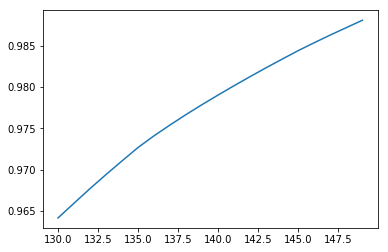

In [21]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit(azdias_scaled)
variance = azdias_pca.explained_variance_ratio_
# Investigate the variance accounted for by each principal component.
components = []
variance_acct = []
for x in range(130,150,1):
    variance_acct.append(sum(variance[0:x+1]))
    components.append(x)
plt.plot(components,variance_acct);

In [6]:
pca = PCA(140)
azdias_pca = pca.fit(azdias_scaled)
azdias_trans = azdias_pca.transform(azdias_scaled)

In [ ]:
azdias_pca.shape

In [21]:
# scree_plot function from Udacity.com lessons
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

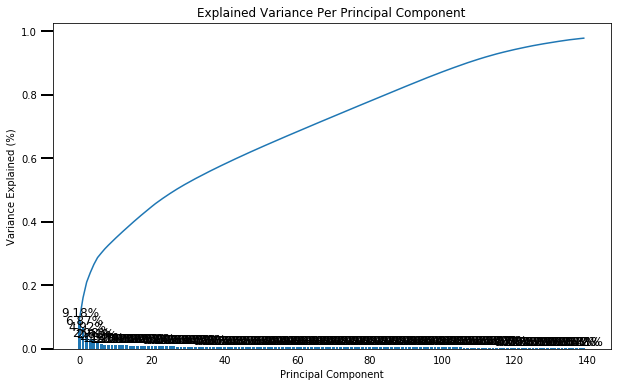

In [22]:
scree_plot(azdias_pca)

In [23]:
azdias_pca.explained_variance_ratio_

array([ 0.09180217,  0.06872072,  0.04922644,  0.02987461,  0.0261507 ,
        0.02127992,  0.01398272,  0.01339567,  0.01178237,  0.01126726,
        0.01092632,  0.01071854,  0.01050808,  0.01040247,  0.01023749,
        0.01010402,  0.00997461,  0.00969246,  0.00956504,  0.00939906,
        0.00929202,  0.00904374,  0.0083541 ,  0.00800895,  0.00772364,
        0.00761202,  0.00739074,  0.00702795,  0.00692605,  0.00652368,
        0.00641739,  0.00637308,  0.00608772,  0.00596347,  0.00592157,
        0.00589814,  0.00579046,  0.00569879,  0.00560946,  0.00552543,
        0.0055004 ,  0.00546465,  0.00539231,  0.0053406 ,  0.0052959 ,
        0.00527244,  0.00521855,  0.00515728,  0.00514243,  0.00507997,
        0.00506121,  0.00502865,  0.00500523,  0.00498623,  0.00497715,
        0.00492649,  0.0049236 ,  0.0049026 ,  0.00488217,  0.00488048,
        0.00486739,  0.00485338,  0.00483842,  0.00483347,  0.0048245 ,
        0.00481711,  0.00481225,  0.00480677,  0.00479524,  0.00

### Discussion 2.2: Perform Dimensionality Reduction
140 of the components (2/3 of the total) accounted for about 98% of the variance

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [10]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

#https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
azdias_map = pd.DataFrame(azdias_pca.components_,columns=azdias_scaled.columns)

def ith_principal(i):
    weights = azdias_map.loc[[0]].sort_values(by=0,axis=1,ascending=False).values[0]
    cols = azdias_map.loc[[i-1]].sort_values(by=i-1,axis=1, ascending=False).columns
    for c, w in zip(cols, weights):
        print(c,w)
        
ith_principal(1)


ZABEOTYP__6 0.196444887403
GEBAEUDETYP__7 0.196444887403
CAMEO_DEU_2015__45 0.196444887403
LP_STATUS_GROB__5 0.194733038613
LP_STATUS_FEIN__10 0.194731938881
GFK_URLAUBERTYP__12 0.193485881209
CAMEO_DEUG_2015__9 0.19324827016
FINANZTYP__6 0.183866055405
NATIONALITAET_KZ__3 0.183623729361
SHOPPER_TYP__4 0.182226932783
LP_FAMILIE_GROB__5 0.181251115885
LP_FAMILIE_FEIN__11 0.18111845351
CAMEO_INTL_2015_WEALTH 0.15361831033
CAMEO_INTL_2015 0.148810253258
FINANZ_HAUSBAUER 0.148322654027
HH_EINKOMMEN_SCORE 0.143787197593
EWDICHTE 0.136105061754
KBA13_ANZAHL_PKW 0.105242430374
PLZ8_ANTG3 0.105115183798
ARBEIT 0.102144730789
W_KEIT_KIND_HH 0.0994900723913
RETOURTYP_BK_S 0.0837562568868
PRAEGENDE_JUGENDJAHRE_DECADE 0.0803336794216
VERS_TYP 0.0796086358978
ANREDE_KZ 0.0793817040961
HEALTH_TYP 0.0787671963341
PRAEGENDE_JUGENDJAHRE 0.0784053325881
REGIOTYP 0.0767399436949
PLZ8_ANTG2 0.070450150114
FINANZ_VORSORGER 0.0644187987044
ORTSGR_KLS9 0.0554340304537
SEMIO_LUST 0.0521825421738
RELAT_AB 0.04

In [28]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
ith_principal(2)



LP_STATUS_GROB__0 0.196444887402
PLZ8_ANTG4 0.196444887402
PLZ8_BAUMAX 0.196444887402
FINANZ_SPARER 0.194733038611
PLZ8_ANTG3 0.194731938879
ORTSGR_KLS9 0.193485881207
KBA05_ANTG4 0.193248270159
LP_STATUS_FEIN__0 0.183866055409
KBA05_ANTG3 0.183623729364
LP_STATUS_FEIN__1 0.182226932786
ANZ_HAUSHALTE_AKTIV 0.181251115887
LP_FAMILIE_GROB__0 0.181118453513
LP_FAMILIE_FEIN__0 0.153618310331
CAMEO_DEUG_2015__8 0.148810253259
FINANZTYP__0 0.148322654032
HH_EINKOMMEN_SCORE 0.14378719759
CAMEO_INTL_2015 0.136105061747
CAMEO_INTL_2015_WEALTH 0.105242430375
FINANZ_UNAUFFAELLIGER 0.105115183774
FINANZ_ANLEGER 0.102144730764
SEMIO_FAM 0.0994900723733
PLZ8_ANTG2 0.0837562568843
CAMEO_DEUG_2015__7 0.0803336794316
RELAT_AB 0.0796086358969
SEMIO_PFLICHT 0.0793817040948
ZABEOTYP__4 0.0787671963234
SEMIO_REL 0.0784053325974
GEBAEUDETYP__2 0.076739943709
EWDICHTE 0.0704501501315
SEMIO_SOZ 0.0644187987109
GFK_URLAUBERTYP__11 0.0554340304425
SEMIO_RAT 0.0521825421796
CAMEO_DEU_2015__35 0.0431458219812
ARB

In [29]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
ith_principal(3)



ALTERSKATEGORIE_GROB 0.196444887402
ZABEOTYP__2 0.196444887402
FINANZ_VORSORGER 0.196444887402
SEMIO_ERL 0.194733038611
SEMIO_LUST 0.194731938879
RETOURTYP_BK_S 0.193485881207
LP_STATUS_FEIN__0 0.193248270159
W_KEIT_KIND_HH 0.183866055409
FINANZTYP__4 0.183623729364
FINANZ_MINIMALIST 0.182226932786
NATIONALITAET_KZ__0 0.181251115887
SHOPPER_TYP__3 0.181118453513
FINANZTYP__1 0.153618310331
PLZ8_ANTG4 0.148810253259
LP_FAMILIE_GROB__0 0.148322654032
LP_FAMILIE_FEIN__0 0.14378719759
PLZ8_BAUMAX 0.136105061747
ORTSGR_KLS9 0.105242430375
FINANZTYP__5 0.105115183774
PLZ8_ANTG3 0.102144730764
GFK_URLAUBERTYP__3 0.0994900723733
SEMIO_KRIT 0.0837562568843
KBA05_ANTG4 0.0803336794316
SEMIO_KAEM 0.0796086358969
LP_STATUS_FEIN__2 0.0793817040948
ANZ_HAUSHALTE_AKTIV 0.0787671963234
FINANZ_HAUSBAUER 0.0784053325974
RELAT_AB 0.076739943709
CAMEO_DEUG_2015__7 0.0704501501315
PLZ8_ANTG2 0.0644187987109
EWDICHTE 0.0554340304425
GFK_URLAUBERTYP__6 0.0521825421796
LP_FAMILIE_GROB__1 0.0431458219812
LP_FA

### Discussion 2.3: Interpret Principal Components

First principal part: ZABEOTYP__6 -- "Indifferent" about energy consumption; GEBAEUDETYP -- "company building";  CAMEO_DEU_2015 -- "Mini-jobber" <<all three of these had high positive values for the first principal part...MOBI_REGIO -- "Movement patterns" 1=very high, 6=none; NATIONALITAET_KZ - "nationality based on given name analysis" -1=German-sounding, 2=foreign-sounding, 3=assimilated name. MOBI_REGIO and NATIONALITAET_KZ both had the most negative variance for the first principal part. 

Second principal part: LP_STATUS_GROB -- "Social status, rough scale"; PLZ8_ANTG3 -- "Number of 6-10 family houses in the PLZ8 region"; PLZ8_ANTG4 - "Number of 10+ family houses in the PLZ8 region" << all three of these had high positive values for the second principal part...FINANZ_MINIMALIST - "low financial interest"...KBA05_GBZ - "number of buildings in the microcell" << both of these had the most negative variance for the second principal part

Third principal part: ALTERSKATEGORIE_GROB -- "Estimated age based on given name analysis"; ZABEOTYP__2 -- "'Smart' energy consumption typology"; FINANZ_VORSORGER -- "'be prepared' financial typology <<these three had high positive values for the third principal part...PRAEGENDE_JUGENDJAHRE and PRAEGENDE_JUGENDJAHRE_DECADE (dominating movement of a person's youth) both had the most negative values for the third principal part.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [8]:
# Over a number of different cluster counts...
clusters = []
distances = []
for x in range(1,25,3):
    model = KMeans(x)
    # run k-means clustering on the data and...
    model.fit(azdias_trans)
    
    # compute the average within-cluster distances.
    score = model.score(azdias_trans)
    distances.append(score)
    clusters.append(x)
    print(score)
    

-184758116.626
-153464604.562
-146003766.947
-142037502.923
-139159291.31
-136743983.564
-134745899.427
-131573242.337


In [9]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
for x, y in zip(clusters, distances):
    print(f"{x}.....{y}")

1.....-184758116.62638152
4.....-153464604.56172535
7.....-146003766.94732806
10.....-142037502.92260373
13.....-139159291.31037408
16.....-136743983.56430784
19.....-134745899.4271506
22.....-131573242.33664209


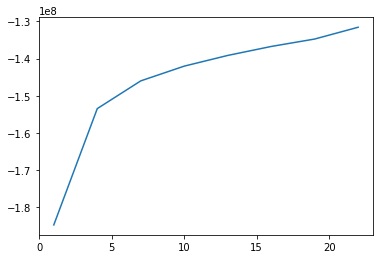

In [10]:
plt.plot(clusters, distances);

There's a sharp change at 4 clusters, and then a slightly less sharp change at 7. We'll use 7 as the number of clusters.

In [12]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(7)
model = model.fit(azdias_trans)
pred = model.predict(azdias_trans)
print(pred)
print(len(azdias_trans),
     len(pred))


[1 4 2 ..., 2 4 6]
891221 891221


In [60]:
type(azdias_trans)

numpy.ndarray

In [13]:
pop_vals, pop_counts = np.unique(pred, return_counts = True)
for x,y in zip(pop_vals, pop_counts):
    print(x,y)

0 116532
1 111068
2 128291
3 145779
4 147654
5 120383
6 121514


### Discussion 3.1: Apply Clustering to General Population

There's a sharp change at 4 clusters, and then a slightly less sharp change at 7. From 7 onward there is gradual increase in the score but a more significant increase in computing time. More clusters also means more difficulty in deciphering results. Given all of these factors, 7 seems like a good number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [14]:
# customers = pd.read_csv('customers')
# customers['GEBAEUDETYP__7'] = np.array(0)

In [10]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', ';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',';')

In [11]:
customers.shape

(191652, 85)

In [34]:
customers.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0


In [11]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers)
customers.head()



OST_WEST_KZ is non-numeric
CAMEO_DEU_2015 is non-numeric
Dropped AGER_TYP
Dropped GEBURTSJAHR
Dropped TITEL_KZ
Dropped ALTER_HH
Dropped KK_KUNDENTYP
Dropped KBA05_BAUMAX
Beginning one-hot encoding.
Completed one-hot enoding.
Data cleaning complete.


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015__40,CAMEO_DEU_2015__41,CAMEO_DEU_2015__42,CAMEO_DEU_2015__43,CAMEO_DEU_2015__44,CAMEO_DEU_2015__45,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,1.0,3.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,4.0,1.0


In [12]:
# customers.to_csv('customers', mode='w', index=False)

In [10]:
# customers = pd.read_csv('customers')

In [11]:
#this column got excluded (probably because there were none in the customer data), so i hard-coded it for now.
customers['GEBAEUDETYP__7'] = np.array(0)

In [20]:
for x in range(0,len(azdias_scaled.columns)):
    print(azdias_scaled.columns[x],customers.columns[x])

ALTERSKATEGORIE_GROB ALTERSKATEGORIE_GROB
ANREDE_KZ ANREDE_KZ
FINANZ_MINIMALIST FINANZ_MINIMALIST
FINANZ_SPARER FINANZ_SPARER
FINANZ_VORSORGER FINANZ_VORSORGER
FINANZ_ANLEGER FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER FINANZ_HAUSBAUER
GREEN_AVANTGARDE GREEN_AVANTGARDE
HEALTH_TYP HEALTH_TYP
LP_LEBENSPHASE_FEIN LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S RETOURTYP_BK_S
SEMIO_SOZ SEMIO_SOZ
SEMIO_FAM SEMIO_FAM
SEMIO_REL SEMIO_REL
SEMIO_MAT SEMIO_MAT
SEMIO_VERT SEMIO_VERT
SEMIO_LUST SEMIO_LUST
SEMIO_ERL SEMIO_ERL
SEMIO_KULT SEMIO_KULT
SEMIO_RAT SEMIO_RAT
SEMIO_KRIT SEMIO_KRIT
SEMIO_DOM SEMIO_DOM
SEMIO_KAEM SEMIO_KAEM
SEMIO_PFLICHT SEMIO_PFLICHT
SEMIO_TRADV SEMIO_TRADV
SOHO_KZ SOHO_KZ
VERS_TYP VERS_TYP
ANZ_PERSONEN ANZ_PERSONEN
ANZ_TITEL ANZ_TITEL
HH_EINKOMMEN_SCORE HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH W_KEIT_KIND_HH
WOHNDAUER_2008 WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV ANZ_HAUSHALTE_AKTIV
AN

In [15]:
customers = impute_df(customers)
customers = scale_df(customers)
customers_trans = azdias_pca.transform(customers)

    


In [16]:
clusters = model.predict(customers_trans)

In [17]:
centers = model.cluster_centers_

In [18]:
amts, counts = np.unique(clusters, return_counts = True)
for x, y in zip(amts, counts):
    print(x,y)

0 129
2 7209
3 181908
4 427
5 1332
6 647


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [28]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

print("Population cluster numbers and percentages of total")
for x in range(0,len(pop_vals)):
    print(f"{pop_vals[x]}....{round(pop_counts[x])}....{round(pop_counts[x] / len(pred) * 100, 2)}%")

print("\nCustomer cluster numbers and percentages of total")
for y in range(0,len(amts)):
    print(f"{amts[y]}....{round(counts[y],2)}....{round(counts[y] / len(clusters) * 100, 2)}%")

Population cluster numbers and percentages of total
0....114221....12.82%
1....158167....17.75%
2....111068....12.46%
3....108698....12.2%
4....197580....22.17%
5....117563....13.19%
6....83924....9.42%

Customer cluster numbers and percentages of total
0....29253....15.26%
1....157757....82.31%
3....331....0.17%
4....1833....0.96%
5....2365....1.23%
6....113....0.06%


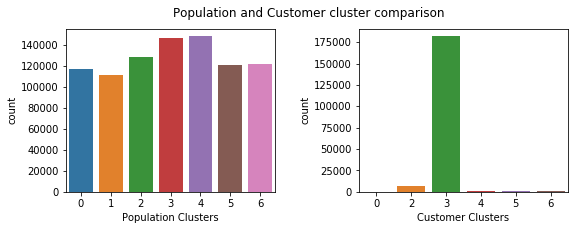

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,3))
fig.suptitle("Population and Customer cluster comparison")
fig.subplots_adjust(wspace=0.4)
sns.countplot(pred, ax=ax1)
sns.countplot(clusters, ax=ax2);
ax1.set_xlabel('Population Clusters')
ax2.set_xlabel('Customer Clusters');

In [20]:
centers.shape

(7, 140)

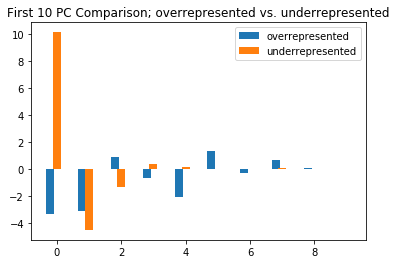

In [42]:
Princ_C = np.arange(0,10)

ax1 = plt.subplot(111)
ax1.bar(Princ_C - 0.2,centers[3][0:10], width = 0.25)
ax1.bar(Princ_C,centers[1][0:10], width = 0.25)
ax1.set_title('First 10 PC Comparison; overrepresented vs. underrepresented')
plt.legend(['overrepresented','underrepresented'])
plt.show()

In [32]:
centers_reverse = azdias_pca.inverse_transform(centers)

In [39]:
centers_df = pd.DataFrame(centers_reverse, columns = azdias_scaled.columns)

In [45]:
over = centers_df.loc[3]
under = centers_df.loc[1]

In [62]:
PC_to_watch = ['ZABEOTYP__6','GEBAEUDETYP__7','CAMEO_DEU_2015__45','MOBI_REGIO','NATIONALITAET_KZ__0','LP_STATUS_GROB__0','PLZ8_ANTG3','PLZ8_ANTG4','ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER']

In [63]:
print("Feature.......Overrepresented.......Underrepresented")
for x in PC_to_watch:
    print(f"{x}.......{over[x]}.......{under[x]}")

Feature.......Overrepresented.......Underrepresented
ZABEOTYP__6.......0.0024714588081591327.......3.0037314568712485
GEBAEUDETYP__7.......0.0024714588081591327.......3.0037314568712485
CAMEO_DEU_2015__45.......0.0024714588081591327.......3.0037314568712485
MOBI_REGIO.......2.6619567616744355.......0.6655672153521845
NATIONALITAET_KZ__0.......2.1355591477165934.......-0.001343963920516611
LP_STATUS_GROB__0.......0.03831601670108897.......-0.0037948576835883374
PLZ8_ANTG3.......0.8402874107403133.......2.158748149491849
PLZ8_ANTG4.......0.23222846382142548.......-0.0052924054714941215
ALTERSKATEGORIE_GROB.......3.525287982067608.......3.1424976494861223
FINANZ_VORSORGER.......3.034196643719449.......3.6181023663844902


## Overrepresented Analysis
I can tell from examining the cluster that it is overrepresented in the customer data that customers are less likely to be in a company building, be a 'mini-jobber', or have a high number of 10+ family houses in the PLZ8 region, and less likely to be financially prepared.

On the other hand, those overrepresented in the customer data are more likely to be as mobile as the underrepresented group, more likely to be a bit older, and more likely to have a German sounding name.

## Underrepresented Analysis

I can tell from examining the cluster that it is underrepresented in the customer data that customers are more likely to be in a company building, be a 'mini-jobber', or have a high number of 10+ family houses in the PLZ8 region, and slightly more likely to be financially prepared.

On the other hand, those overrepresented in the customer data are less likely to be as mobile as the overrepresented group, less likely to be a bit older, and less likely to have a German sounding name.

### Discussion 3.3: Compare Customer Data to Demographics Data

Given it's a mail-order company, it's somewhat unsurprising that the non-mobile elderly are popular customers. Mobility could limit the ability to go buy something, and mail-order provides convenience. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.